In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import expon
from scipy.stats import poisson

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from datetime import datetime, timedelta
from dateutil.parser import parse
import math
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
import os

import matplotlib.pyplot as plt

 
%matplotlib inline

Read csv and create figure size for notebook

In [2]:
plt.rcParams["figure.figsize"] = (20,10)
ufo = pd.read_csv('/Users/richardlafferty/Downloads/scrubbed.csv')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Rename columns for easier input

In [3]:
ufo.rename(columns = {'duration (seconds)':'duration_seconds',
                      'duration (hours/min)': 'duration_hrs_min',
                      'date posted': 'date_posted'}, inplace = True)

Replacing incompatible timestamps

In [4]:
ufo['datetime'] = ufo['datetime'].apply(lambda x: x + ':00')

In [5]:
ufo.datetime.replace('24:00:00', '00:00:00')


0        10/10/1949 20:30:00
1        10/10/1949 21:00:00
2        10/10/1955 17:00:00
3        10/10/1956 21:00:00
4        10/10/1960 20:00:00
5        10/10/1961 19:00:00
6        10/10/1965 21:00:00
7        10/10/1965 23:45:00
8        10/10/1966 20:00:00
9        10/10/1966 21:00:00
10       10/10/1968 13:00:00
11       10/10/1968 19:00:00
12       10/10/1970 16:00:00
13       10/10/1970 19:00:00
14       10/10/1971 21:00:00
15       10/10/1972 19:00:00
16       10/10/1972 22:30:00
17       10/10/1973 19:00:00
18       10/10/1973 23:00:00
19       10/10/1974 19:30:00
20       10/10/1974 21:30:00
21       10/10/1974 23:00:00
22       10/10/1975 17:00:00
23       10/10/1976 20:30:00
24       10/10/1976 22:00:00
25       10/10/1977 12:00:00
26       10/10/1977 22:00:00
27       10/10/1978 02:00:00
28       10/10/1979 00:00:00
29       10/10/1979 22:00:00
                ...         
80302      9/9/2012 20:00:00
80303      9/9/2012 20:10:00
80304      9/9/2012 20:30:00
80305      9/9

Seperating date from time

In [6]:
ufo['date'] = ufo['datetime'].map(lambda x: str(x)[:-8])
ufo['date'] = ufo['date'].str.strip()
ufo['year'] = ufo['date'].map(lambda x: str(x)[-4:])
ufo['year'] = ufo['year'].str.split('/')
ufo['time'] = ufo['datetime'].map(lambda x: str(x)[-8:])


Convert datetime by adding date and time seperately

In [7]:
ufo['datetime'] = pd.to_datetime(ufo.date) + pd.to_timedelta(ufo.time)

Change year column to be the year of datetime which is an integer

In [8]:
ufo['year'] = ufo['datetime'].dt.year

In [9]:
print(ufo.datetime.dtypes)

datetime64[ns]


change latitude from an object to a float

In [10]:
ufo['latitude'] = pd.to_numeric(ufo['latitude'], errors = 'coerce')


Strip whitespace in longitude header

In [11]:
ufo.rename(columns = {'longitude ': 'longitude'}, inplace = True)

Creating new Data Frames. One starting at the lower whisker of the boxplot of the total sighting. Other starting after.

In [12]:
#Making two new data frames
ufo['year'] = ufo['year'].astype(int)
ufo_b4_1993 = ufo[ufo['year'] < 1993]
ufo_after_1993 = ufo[(ufo['year'] >= 1993) & (ufo['year'] <= 2013)]

Changing the duration in seconds to a float

In [13]:
ufo['duration_seconds'] = pd.to_numeric(ufo.duration_seconds, errors = 'coerce')
print(ufo['duration_seconds'].dtypes)
print(ufo.duration_seconds.describe())

float64
count    8.032900e+04
mean     9.017226e+03
std      6.202284e+05
min      1.000000e-03
25%      3.000000e+01
50%      1.800000e+02
75%      6.000000e+02
max      9.783600e+07
Name: duration_seconds, dtype: float64


In [14]:
print(ufo.dtypes)

datetime            datetime64[ns]
city                        object
state                       object
country                     object
shape                       object
duration_seconds           float64
duration_hrs_min            object
comments                    object
date_posted                 object
latitude                   float64
longitude                  float64
date                        object
year                         int64
time                        object
dtype: object


In [15]:
ufo['state'] = ufo.state.str.upper()
state_seen = ufo.groupby('state').state.agg(['count'])
#ufo_states = ufo['state'].replace(lambda x: states.values())

#print(state_seen)
#print(ufo_states)

In [16]:
#top ten shapes
light = ufo.loc[ufo['shape'] == 'light']
triangle = ufo.loc[ufo['shape'] == 'triangle']
circle = ufo.loc[ufo['shape'] == 'circle']
formation = ufo.loc[ufo['shape'] == 'formation']
oval = ufo.loc[ufo['shape'] == 'oval']
disk = ufo.loc[ufo['shape'] == 'disk']
sphere = ufo.loc[ufo['shape'] == 'sphere']
unknown = ufo.loc[ufo['shape'] == 'unknown']
other = ufo.loc[ufo['shape'] == 'other']

fireball = ufo.loc[ufo['shape'] == 'fireball']
everything_else = ufo.loc[ufo['shape'] != 'light']


# Taking a look at our UFO data

Let's start by taking a zoomed out view of the world and where our sightings have been most prevalent.

/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.


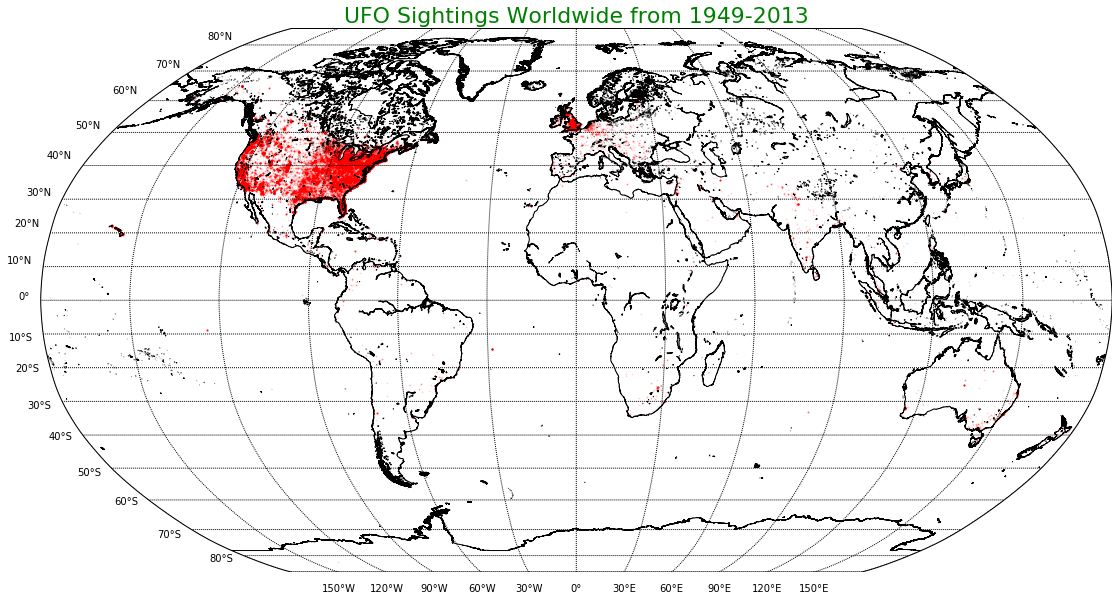

In [17]:
m = Basemap(projection='robin',lon_0=0,resolution='f')
m.drawcoastlines()
m.drawparallels(np.arange(-90, 90, 10), labels = [True, False, False, False])
m.drawmeridians(np.arange(-180, 180, 30), labels = [0, 0, 0, 1])

m.scatter(ufo.longitude.to_list(), ufo.latitude.to_list(), latlon = True, s = 1, c = 'red', alpha = .1)
plt.title('UFO Sightings Worldwide from 1949-2013', fontsize = 22, color = 'green')
plt.show()

As you can see, UFO sighting isn't necessarily an American phenomena, but it would appear that we are by far the most likely to have an occurence of seeing an Unidentified Flying Object. So let's go ahead and take a closer look into America and where sightings are most likely to occur.

/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


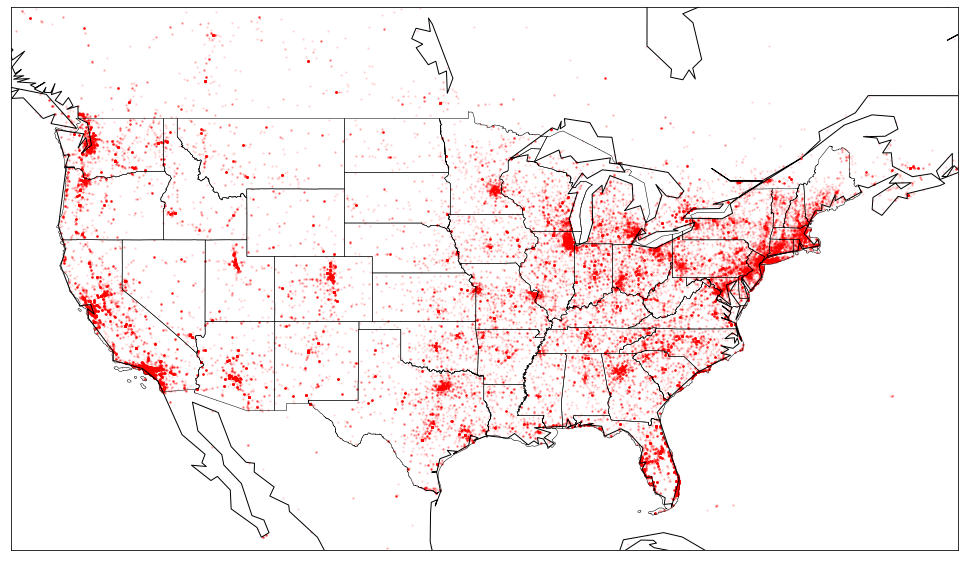

In [18]:
m = Basemap(projection = 'mill',
           llcrnrlat = 22,
           urcrnrlat = 55,
           llcrnrlon = -128,
           urcrnrlon = -60,
           resolution = 'c')
m.drawcoastlines()
m.readshapefile('/Users/richardlafferty/Downloads/tl_2017_us_state/tl_2017_us_state', 'areas')
m.scatter(ufo.longitude.to_list(), ufo.latitude.to_list(), latlon = True, s = 2, c = 'red', alpha = .1)


# UFO sightings by state
Now that we've taken a deeper look into the US territory, it's plain to see that there are some serious hot spots. The question is why. What makes some areas more likely to have a sighting than others? We'll start to dive into that here in the next few cells.

In [28]:
state_count = ufo.state.value_counts()
state_count_pct = ufo.state.value_counts(normalize = True)
top_ten_states = state_count.head(10)




## California
Now we can look into California. The wealth of data points make it an ideal sample to look at.

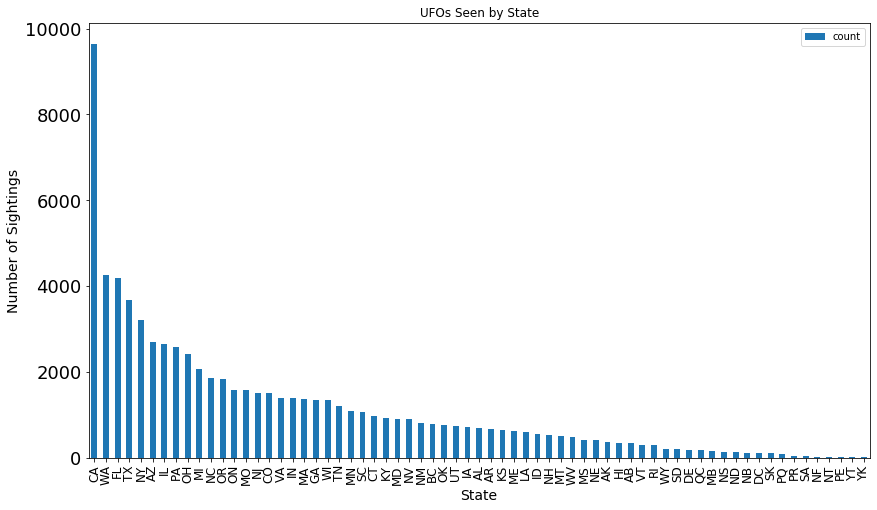

In [20]:
ax = state_seen.sort_values(by = 'count', ascending = False).plot(kind = 'bar',
                                                                  figsize = (14, 8),
                                                                  title = 'UFOs Seen by State', fontsize = 18)
ax.set_xlabel('State', fontsize = 14)
ax.set_ylabel('Number of Sightings', fontsize = 14)
ax.tick_params(axis = 'x', labelsize = 12)



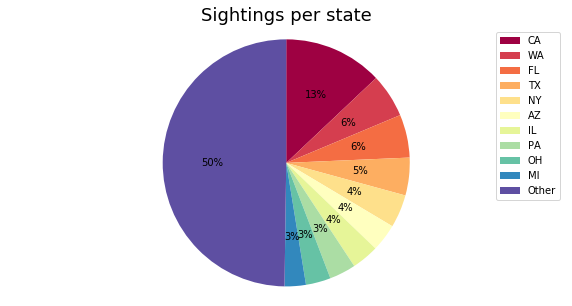

In [21]:
state_counts = pd.DataFrame(ufo.state.value_counts())
other = int(state_counts[10:].sum())
state_counts = state_counts[:10]
state_counts.loc[11] = other
state_counts = state_counts.rename(index={11: 'Other'})

plt.figure(figsize=(10, 5))
plt.pie(state_counts.state, autopct='%1.0f%%', colors = ['#9e0142',
'#d53e4f',
'#f46d43',
'#fdae61',
'#fee08b',
'#ffffbf',
'#e6f598',
'#abdda4',
'#66c2a5',
'#3288bd',
'#5e4fa2'], 
   counterclock = False,
       startangle = -270)
plt.axis('equal')
plt.title('Sightings per state', fontsize = 18, )
plt.legend(state_counts.index)

In [22]:
shapes_seen = ufo.groupby('shape').shape.agg(['count'])
#shape_count = shapes_seen.value_counts()
#shape_count_pct = shapes_seen.value_counts(normalize = True)


So when looking at a map of california we can see two things.

1: There is an inoordinate amount of sightings are centered around Los Angeles

2: There seems to be a pattern of sightings located near urban areas.

If we go back and look at the rest of America, I would wager that the concentrated sightings would all be centered around urban areas. That leads me to believe that either there is increased military activity in said areas an/or there is more technology which would mean more UFOs. 

The other theory if we wanted to get more conspiratorial would be that the E.T.s are just more interested in our denser areas of population. I tend to fall in the former thought process.

/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


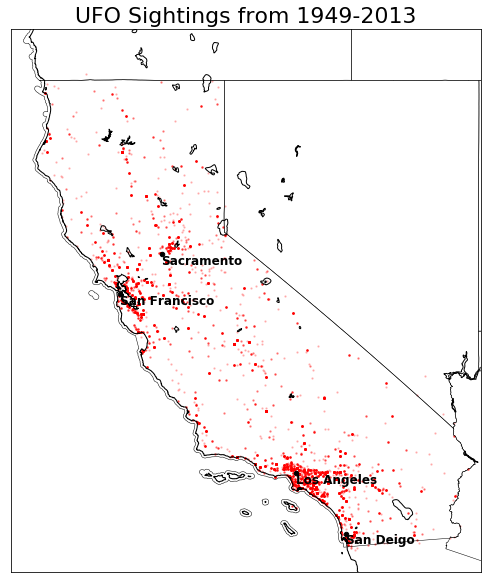

In [23]:
california = ufo.loc[ufo['state'] == 'CA']

m = Basemap(projection = 'mill',
           llcrnrlat = 32,
           urcrnrlat = 43,
           llcrnrlon = -125,
           urcrnrlon = -114,
           resolution = 'f')
plt.title('UFO Sightings from 1949-2013', fontsize = 22)
m.drawcoastlines()

m.readshapefile('/Users/richardlafferty/Downloads/tl_2017_us_state/tl_2017_us_state', 'counties')

m.scatter(california.longitude.to_list(), california.latitude.to_list(), latlon = True, s = 2, c = 'red',  alpha = .2)
#m.scatter(california_everything_else.longitude.to_list(), california_everything_else.latitude.to_list(), latlon = True, s = 2, c = 'blue', alpha = .2)

m.scatter([-121.47, -122.45, -118.33, -117.15], [38.56, 37.75, 34.08, 32.81], latlon = True, s = 20, alpha = 1, c = 'black')

sclon = -121.47
sclat = 38.56
x, y = m(sclon, sclat)  
plt.text(x, y, 'Sacramento', fontsize=12 , fontweight='bold', ha='left', va='top', color='k')

sflon = -122.45
sflat = 37.75
x, y = m(sflon, sflat)
plt.text(x, y, 'San Francisco', fontsize=12, fontweight='bold', ha='left', va='top', color='k')

lalon = -118.33
lalat = 34.08
x, y = m(lalon, lalat)
plt.text(x, y, 'Los Angeles', fontsize=12, fontweight='bold', ha='left', va='top', color='k')

sdlon = -117.15
sdlat = 32.81
x, y = m(sdlon, sdlat)
plt.text(x, y, 'San Deigo', fontsize=12, fontweight='bold', ha='left', va='top', color='k')



city_lons = [-121.47, -122.45, -118.33, -117.15]
city_lats = [38.56, 37.75, 34.08, 32.81]

Text(0, 0.5, 'Number of Sightings')

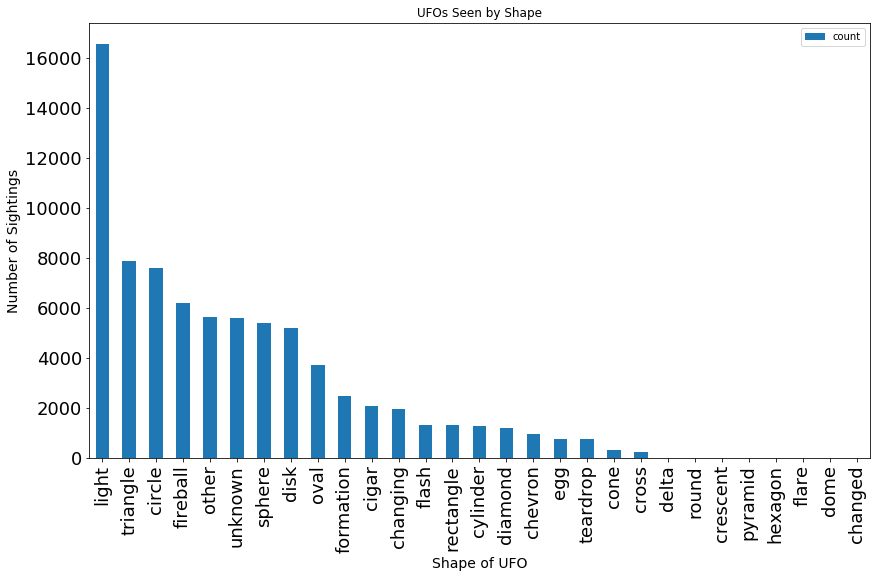

In [24]:

ax = shapes_seen.sort_values(by = 'count', ascending = False).plot(kind = 'bar',
                                                                  figsize = (14, 8),
                                                                  title = 'UFOs Seen by Shape', fontsize = 18)
ax.set_xlabel('Shape of UFO', fontsize = 14)
ax.set_ylabel('Number of Sightings', fontsize = 14)




Text(0, 0.5, 'Number of Sightings')

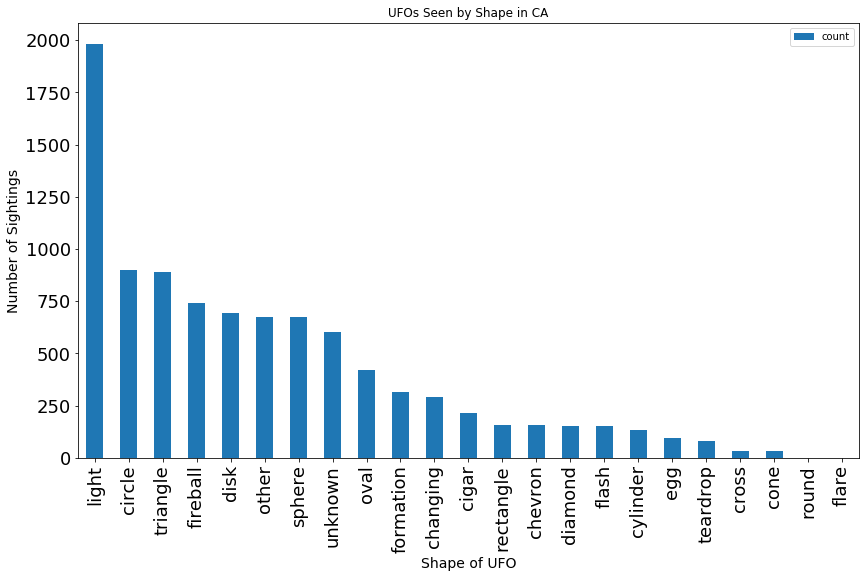

In [58]:
california_everything_else = everything_else.loc[everything_else['state'] == 'CA']
california_light = light.loc[light['state'] == 'CA']
california = ufo.loc[ufo['state'] == 'CA']
shapes_seen_ca = california.groupby('shape').shape.agg(['count'])
ax = shapes_seen_ca.sort_values(by = 'count', ascending = False).plot(kind = 'bar',
                                                                  figsize = (14, 8),
                                                                  title = 'UFOs Seen by Shape in CA', fontsize = 18)
ax.set_xlabel('Shape of UFO', fontsize = 14)
ax.set_ylabel('Number of Sightings', fontsize = 14)


/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


Text(0.5, 1.0, 'Amount of sightings by shape in California')

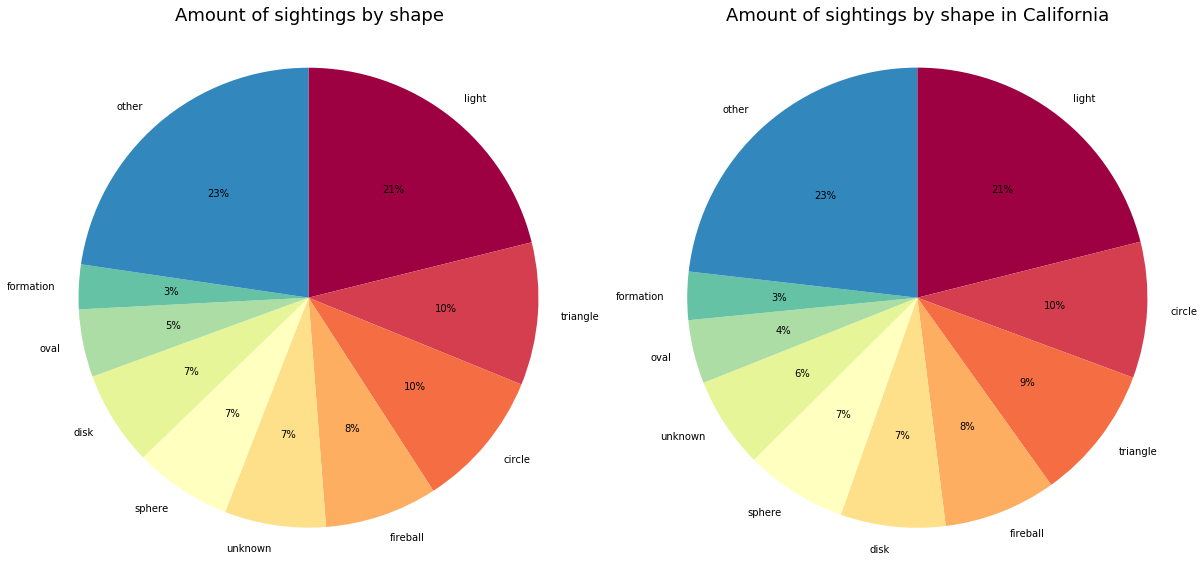

In [59]:

#getting values from data frame column going from biggest to smallest occurrence
shape_counts = shapes_seen.sort_values(by = 'count', ascending = False)
#choosing top 10 and reassigning the rest to an 'other column'
other = int(shape_counts[10:].sum())
shape_counts = shape_counts[:10]
#adding values from existing other column to newly made other category
shape_counts.loc['other'] += other
#resorting values from highest to lowest again
shape_counts = shape_counts.sort_values(by = 'count', ascending = False)
#turning index into list to .pop and reset index, putting other column to last position
index = shape_counts.index.tolist()
index.pop(0)
shape_counts = shape_counts.reindex(index + ['other'])

ax = plt.subplot(121)
#plt.figure(figsize=(10, 5))
ax.pie(shape_counts, autopct='%1.0f%%', colors = ['#9e0142',
'#d53e4f',
'#f46d43',
'#fdae61',
'#fee08b',
'#ffffbf',
'#e6f598',
'#abdda4',
'#66c2a5',
'#3288bd',
'#5e4fa2'], 
   counterclock = False,
       startangle = -270,
      labels = shape_counts.index)
plt.axis('equal')
ax.set_title('Amount of sightings by shape', fontsize = 18, )
#plt.legend(shape_counts.index)




#getting values from data frame column going from biggest to smallest occurrence
shape_counts = shapes_seen_ca.sort_values(by = 'count', ascending = False)
#choosing top 10 and reassigning the rest to an 'other column'
other = int(shape_counts[10:].sum())
shape_counts = shape_counts[:10]
#adding values from existing other column to newly made other category
shape_counts.loc['other'] += other
#resorting values from highest to lowest again
shape_counts = shape_counts.sort_values(by = 'count', ascending = False)
#turning index into list to .pop and reset index, putting other column to last position
index = shape_counts.index.tolist()
index.pop(0)
shape_counts = shape_counts.reindex(index + ['other'])

ax1 = plt.subplot(122)
#plt.figure(figsize=(10, 5))
ax1.pie(shape_counts, autopct='%1.0f%%', colors = ['#9e0142',
'#d53e4f',
'#f46d43',
'#fdae61',
'#fee08b',
'#ffffbf',
'#e6f598',
'#abdda4',
'#66c2a5',
'#3288bd',
'#5e4fa2'], 
   counterclock = False,
       startangle = -270,
       labels = shape_counts.index)
plt.axis('equal')
ax1.set_title('Amount of sightings by shape in California', fontsize = 18, )
#plt.legend(shape_counts.index)

## Sightings by year

Below we will see the number of sightings by year fo sighting. I split the data into three groups using the lower whisker of 1.5 times the IQR.

1: Total sightings

2: Sightings before 1993

3: Sightings after 1992

Looking at the plots below, the differences will be apparent. 

count    80332.000000
mean      2003.850110
std         10.426848
min       1906.000000
25%       2001.000000
50%       2006.000000
75%       2011.000000
max       2014.000000
Name: year, dtype: float64


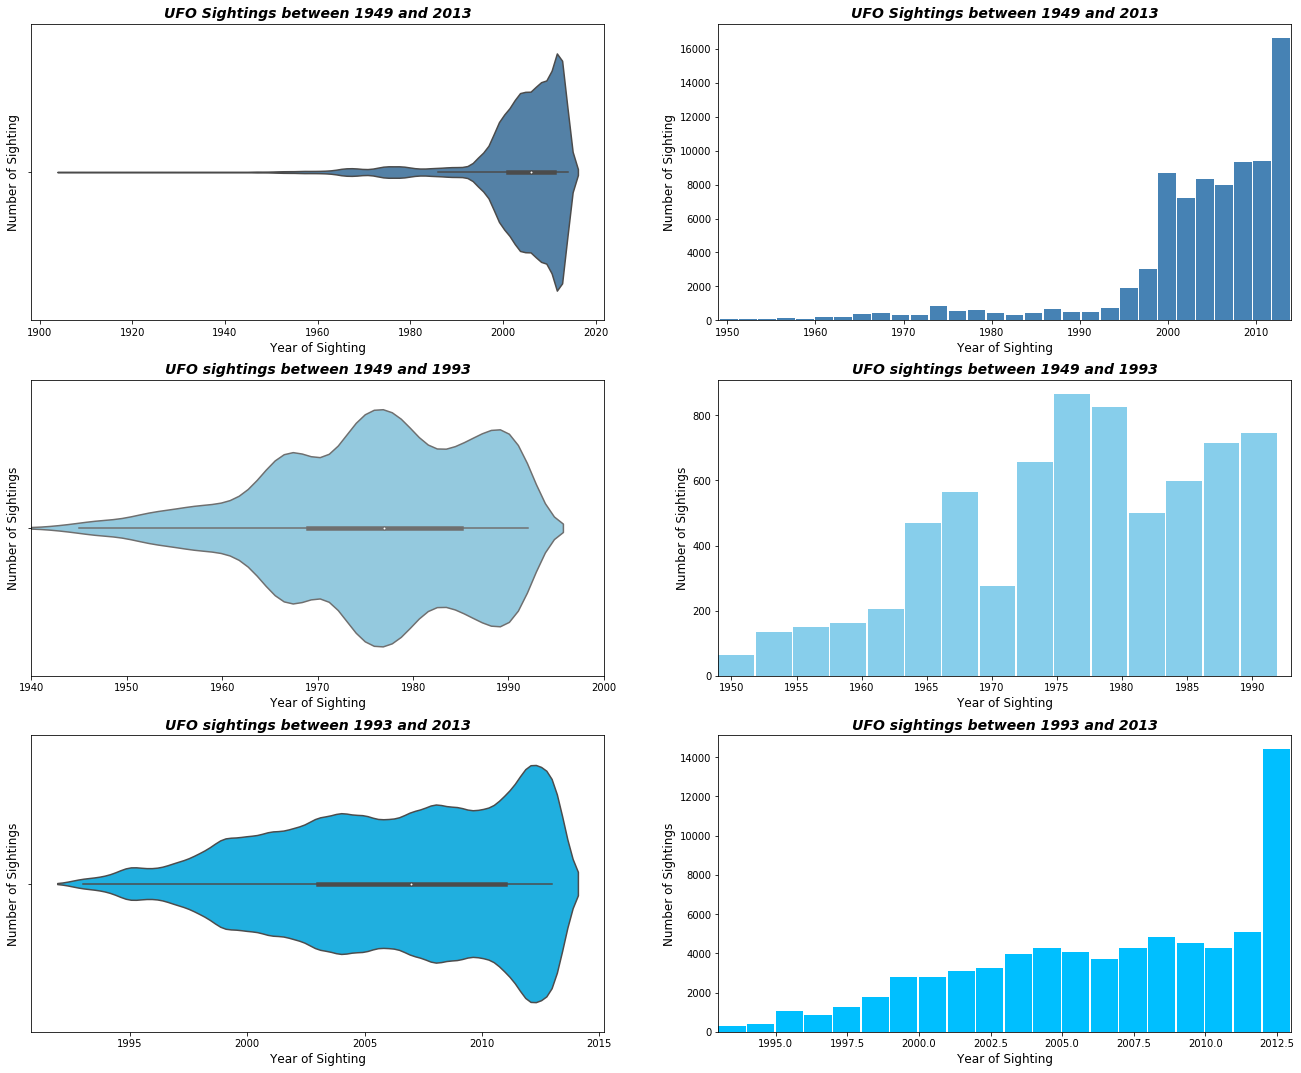

In [26]:
ax = plt.subplot(321)
sns.violinplot(ufo['year'], color = 'steelblue')
ax.set_xlabel('Year of Sighting', fontsize = 12)
ax.set_ylabel('Number of Sighting', fontsize = 12)
ax.set_title('UFO Sightings between 1949 and 2013', fontsize = 14, style = 'italic', fontweight = 'bold')

ax1 = plt.subplot(322)
ax1.hist(ufo['year'], bins = 50, color = 'steelblue', width = 2)
ax1.set_xlabel('Year of Sighting', fontsize = 12)
ax1.set_ylabel('Number of Sighting', fontsize = 12)
ax1.set_title('UFO Sightings between 1949 and 2013', fontsize = 14, style = 'italic', fontweight = 'bold')
ax1.set_xlim(1949, 2014)


ax2 = plt.subplot(323)
sns.violinplot(ufo_b4_1993['year'], color = 'skyblue')
ax2.set_xlabel('Year of Sighting', fontsize = 12)
ax2.set_ylabel('Number of Sightings', fontsize = 12)
ax2.set_title('UFO sightings between 1949 and 1993', fontsize = 14, style = 'italic', fontweight = 'bold')
ax2.set_xlim(1940, 2000)

ax3 = plt.subplot(324)
ax3.hist(ufo_b4_1993['year'], bins = 30, color = 'skyblue', width = 2.75)
ax3.set_xlabel('Year of Sighting', fontsize = 12)
ax3.set_ylabel('Number of Sightings', fontsize = 12)
ax3.set_title('UFO sightings between 1949 and 1993', fontsize = 14, style = 'italic', fontweight = 'bold')
ax3.set_xlim(1949, 1993)

ax4 = plt.subplot(325)
sns.violinplot(ufo_after_1993['year'], color = 'deepskyblue')
ax4.set_xlabel('Year of Sighting', fontsize = 12)
ax4.set_ylabel('Number of Sightings', fontsize = 12)
ax4.set_title('UFO sightings between 1993 and 2013', fontsize = 14, style = 'italic', fontweight = 'bold' )

ax5 = plt.subplot(326)
ax5.hist(ufo_after_1993['year'], bins = 20, color = 'deepskyblue', width = .95)
ax5.set_xlabel('Year of Sighting', fontsize = 12)
ax5.set_ylabel('Number of Sightings', fontsize = 12)
ax5.set_title('UFO sightings between 1993 and 2013', fontsize = 14, style = 'italic', fontweight = 'bold' )
ax5.set_xlim(1993, 2013)

plt.subplots_adjust(bottom=0.1, right=1, top=1.5)

print(ufo['year'].describe())


I think when looking at this data that we can see one very telling thing. The internet led to a rise in UFO sightings at the very least being reported. With very little google searching I was able to find an article that almost perfectly aligns with the data that I've been able to show. https://www.quora.com/When-did-the-Internet-really-become-widely-used. 

Below I will show some tests of the central limit theorum which should be obvious by looking at the data, but I still think important to really demonstrate the extreme change in the amount of data available after the dawn of the internet age.

In [38]:
sample_b4_93 = np.random.choice(ufo_b4_1993['year'], 1000, replace = True)
sample_after_93 = np.random.choice(ufo_after_1993['year'], 1000, replace = True)
sample_total = np.random.choice(ufo['year'], 1000, replace = True)

The difference
0.370188878817287
t-value before 93: 62.00577391236173 and p-value before 93: 0.0
t-value after 93: -5.464338326052179 and p-value after 92: 5.2271245136615986e-08


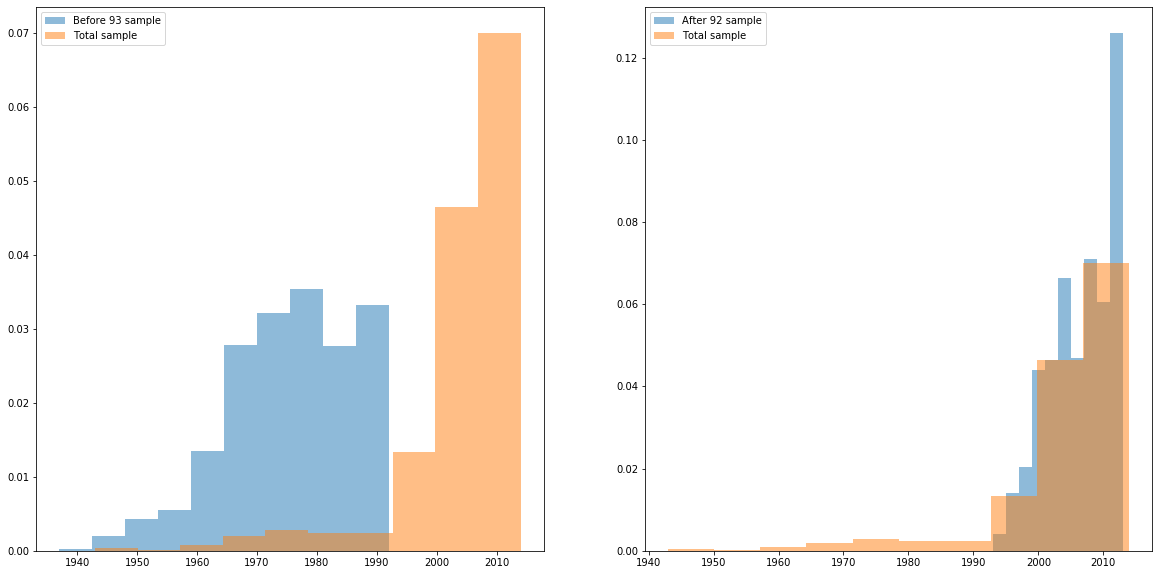

In [56]:
ax = plt.subplot(121)
ax.hist(sample_b4_93, alpha = .5, label = 'Before 93 sample', density = True)
ax.hist(sample_total, alpha = .5, label = 'Total sample', density = True)

plt.legend(loc = 'upper left')

ax1 = plt.subplot(122)
ax1.hist(sample_after_93, alpha = .5, label = 'After 92 sample', density = True)
ax1.hist(sample_total, alpha = .5, label = 'Total sample', density = True)

plt.legend(loc = 'upper left')


size = np.array([len(sample_after_93), len(sample_b4_93)])
sd = np.array([sample_after_93.std(), sample_b4_93.std()])
diff = sample_after_93.mean() - sample_b4_93.mean()
diff_se = (sum(sd ** 2 / size)) ** 0.5 

print('The difference')
print(diff_se)

tval, pval = ttest_ind(sample_total, sample_b4_93)

print('t-value before 93: {} and p-value before 93: {}'.format(tval, pval))

tval1, pval1 = ttest_ind(sample_total, sample_after_93)

print('t-value after 93: {} and p-value after 92: {}'.format(tval1, pval1))



After taking samples from all three data frames we're able to see with both the histogram and our ttest that our theory holds true. Over time UFO sightings, or at least reported sightings, has increased at an incredible rate.

(1949, 2014)

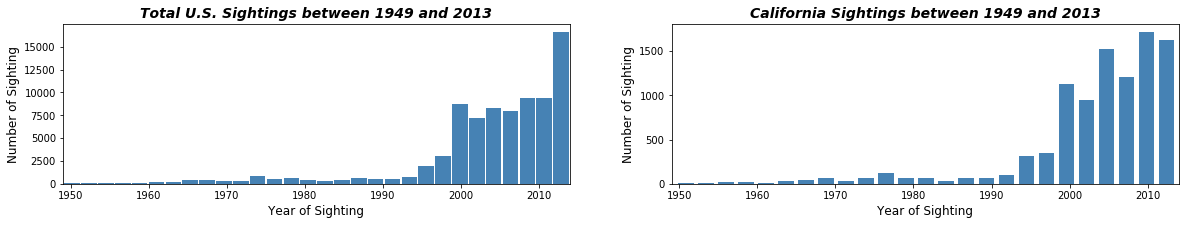

In [36]:
ax1 = plt.subplot(321)
ax1.hist(ufo['year'], bins = 50, color = 'steelblue', width = 2)
ax1.set_xlabel('Year of Sighting', fontsize = 12)
ax1.set_ylabel('Number of Sighting', fontsize = 12)
ax1.set_title('Total U.S. Sightings between 1949 and 2013', fontsize = 14, style = 'italic', fontweight = 'bold')
ax1.set_xlim(1949, 2014)

ax1 = plt.subplot(322)
ax1.hist(california['year'], bins = 30, color = 'steelblue', width = 2)
ax1.set_xlabel('Year of Sighting', fontsize = 12)
ax1.set_ylabel('Number of Sighting', fontsize = 12)
ax1.set_title('California Sightings between 1949 and 2013', fontsize = 14, style = 'italic', fontweight = 'bold')
ax1.set_xlim(1949, 2014)

t-value total: -0.42107245697712137 and p-value total: 0.6737845803395881
t-value before 93: 26.68924939887065 and p-value before 93: 2.328062700156348e-121
t-value after 92: -1.0315011740187803 and p-value after 92: 0.3025330073774083


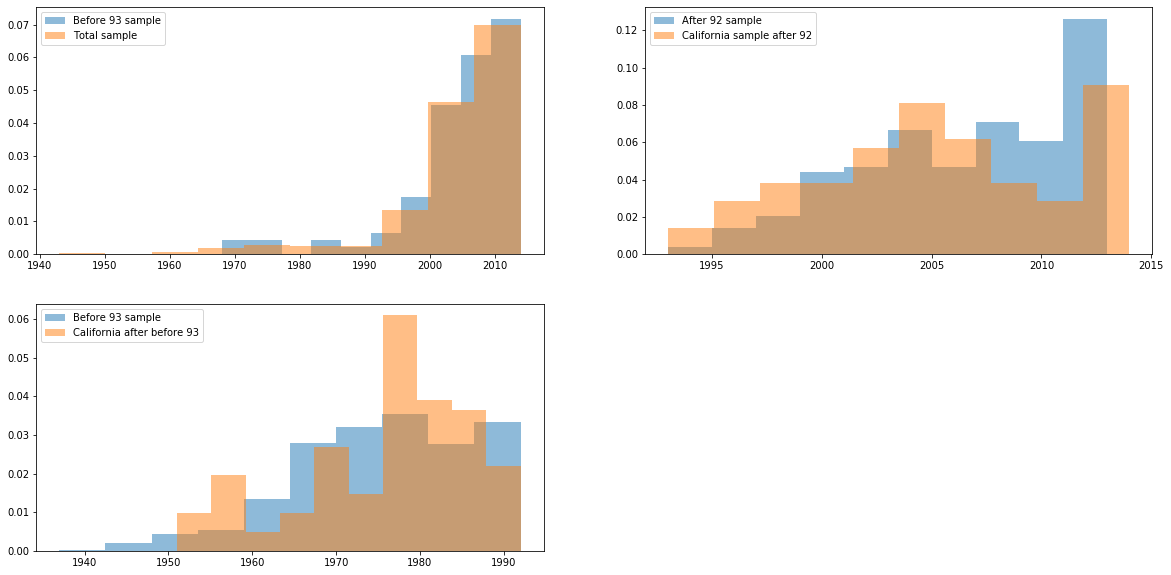

In [55]:
ca_b4_93 = california.loc[california['year'] < 1993]
ca_after_93 = california.loc[california['year'] >= 1993]

sample_total = np.random.choice(ufo['year'], 1000, replace = True)
california_sample = np.random.choice(california['year'], 100, replace = True)
california_sample_b4 = np.random.choice(ca_b4_93['year'], 100, replace = True)
california_sample_after = np.random.choice(ca_after_93['year'], 100, replace = True)
#plot 3 histograms and print their p-values. Use density to normalize. Normed was deprecated. 
ax = plt.subplot(221)
ax.hist(california_sample, alpha = .5, label = 'Before 93 sample', density = True)
ax.hist(sample_total, alpha = .5, label = 'Total sample', density = True)

plt.legend(loc = 'upper left')

ax1 = plt.subplot(222)
ax1.hist(sample_after_93, alpha = .5, label = 'After 92 sample', density = True)
ax1.hist(california_sample_after, alpha = .5, label = 'California sample after 92', density = True)

plt.legend(loc = 'upper left')

ax2 = plt.subplot(223)
ax2.hist(sample_b4_93, alpha = .5, label = 'Before 93 sample', density = True)
ax2.hist(california_sample_b4, alpha = .5, label = 'California after before 93', density = True)

plt.legend(loc = 'upper left')


tval, pval = ttest_ind(sample_total, california_sample)

print('t-value total: {} and p-value total: {}'.format(tval, pval))

tval, pval = ttest_ind(sample_total, california_sample_b4)

print('t-value before 93: {} and p-value before 93: {}'.format(tval, pval))

tval1, pval1 = ttest_ind(sample_total, california_sample_after)

print('t-value after 92: {} and p-value after 92: {}'.format(tval1, pval1))

